In [9]:
using DrWatson
@quickactivate
include(srcdir("main.jl"))

using CairoMakie

In [10]:
# j_events_taus = load_taus(60:-10:20);
wind_df = load(; name="Wind", ts=missing);
jno_df = load();

┌ Warning: automatically converting Arrow.Timestamp with precision = NANOSECOND to `DateTime` which only supports millisecond precision; conversion may be lossy; to avoid converting, pass `Arrow.Table(source; convert=false)
└ @ Arrow /Users/zijin/.julia/packages/Arrow/JemT3/src/eltypes.jl:273


Row,time,index_diff,len,std,index_std,index_fluctuation,tstart,tstop,t_us,t_ds,fit.vars.amplitude,fit.vars.sigma,t.d_time,d_star,fit.vars.c,fit.stat.rsquared,fit.stat.chisqr,e_max,e_min,b_mag,b_n,B.vec.before,B.vec.after,B.before,B.after,db_mag,bn_over_b,db_over_b,db_over_b_max,dB_lmn,dB,n_cross,duration,n,VX (GSE),VY (GSE),VZ (GSE),T,V,n.before,VX (GSE).before,VY (GSE).before,VZ (GSE).before,T.before,V_us,n.after,VX (GSE).after,VY (GSE).after,VZ (GSE).after,T.after,V_ds,V_n_cross,L_n_cross,j0_k,ion_inertial_length,Alfven_speed,j_Alfven,dB_norm,ω,ω_in,θ_nk,B.mean,n.mean,dB_over_B,dn_over_n,j0_k_norm,L_n_cross_norm,T.mean,β,accuracy,tau,ts
,DateTime?,Float64?,UInt32?,Float64?,Float64?,Float64?,DateTime?,DateTime?,DateTime?,DateTime?,Float64?,Float64?,DateTime?,Float64?,Float64?,Float64?,Float64?,Tuple…?,Tuple…?,Quantity…,Float64?,Tuple…?,Tuple…?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Tuple…?,Tuple…?,Tuple…?,Float64?,Quantity…,Float64?,Float64?,Float64?,Quantity…?,Tuple…?,Float64?,Float64?,Float64?,Float64?,Float64?,Tuple…?,Float64?,Float64?,Float64?,Float64?,Float64?,Tuple…?,Float64?,Quantity…,Float64,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Bool,Second,Missing
1,2011-08-25T11:55:30,0.363093,652,0.424472,2.18293,1.10338,2011-08-25T11:55:00,2011-08-25T11:56:00,2011-08-25T11:55:01.940,2011-08-25T11:55:58.704,-0.778137,1.686,2011-08-25T11:55:33.761,-0.115382,0.107502,0.907229,8.27946,"(-0.470478, 0.727033, 0.500074)","(0.874378, 0.460404, 0.153269)",3.47177 nT,-3.43157,"(0.445282, -0.100624, -3.41998)","(-0.776423, 0.43853, -3.44889)",3.45032,3.56231,0.11199,-0.988422,0.0322572,0.0687599,"(1.22171, -0.539154, 0.0289132)","(0.613558, -1.17616, -0.155848)","(-0.0586135, -0.16112, 0.985193)",3.372,2.36013 cm⁻³,missing,missing,missing,61433.2 K,"(missing, missing, missing)",2.48155,missing,missing,missing,33.0432,"(missing, missing, missing)",2.37579,missing,missing,missing,32.1086,"(missing, missing, missing)",NaN,NaN km,NaN,148.223,49.2789,18.6341,1.3357,21.885,163.276,88.5348,3.50631,2.42867,-0.0319395,0.0435456,NaN,NaN,32.5759,0.417407,false,60 seconds,missing
2,2011-08-25T12:03:00,0.527776,652,1.18646,3.17,1.01956,2011-08-25T12:02:30,2011-08-25T12:03:30,2011-08-25T12:02:39.364,2011-08-25T12:03:09.356,-2.95977,1.23137,2011-08-25T12:03:05.644,-0.600909,1.41784,0.980609,4.04564,"(-0.387427, -0.326064, 0.862313)","(0.544193, 0.674127, 0.499405)",3.51504 nT,-3.00175,"(1.68708, -0.937459, -3.01716)","(-1.57915, -1.19984, -2.82757)",3.58166,3.45376,-0.1279,-0.853973,0.0363864,0.0869124,"(3.26623, 0.262381, -0.189589)","(1.17335, 1.3667, -2.7438)","(0.545212, -0.819789, -0.175188)",2.46274,2.40708 cm⁻³,missing,missing,missing,64485.1 K,"(missing, missing, missing)",2.39789,missing,missing,missing,33.0306,"(missing, missing, missing)",2.38211,missing,missing,missing,33.7223,"(missing, missing, missing)",NaN,NaN km,NaN,146.77,49.4042,19.053,3.28223,55.5825,113.713,110.086,3.51771,2.39,0.0363588,0.00660255,NaN,NaN,33.3764,0.435924,false,60 seconds,missing
3,2011-08-25T12:45:30,0.738704,652,1.2145,4.73201,2.10645,2011-08-25T12:45:00,2011-08-25T12:46:00,2011-08-25T12:45:14.940,2011-08-25T12:45:52.936,-3.14849,4.88015,2011-08-25T12:45:32.158,-0.161291,1.63981,0.953681,24.9655,"(-0.742367, -0.508084, 0.436741)","(0.627257, -0.297974, 0.719555)",3.65125 nT,-3.29951,"(1.72941, 0.789968, -3.2004)","(-1.57709, 0.770428, -3.19866)",3.72256,3.64859,-0.0739696,-0.903664,0.0202587,0.0472325,"(3.3065, 0.0195397, -0.00173913)","(2.45113, 1.69525, -1.43228)","(0.381447, -0.852829, -0.356624)",9.7603,2.42108 cm⁻³,missing,missing,missing,68022.9 K,"(missing, missing, missing)",2.41114,missing,missing,missing,32.7632,"(missing, missing, missing)",2.39608,missing,missing,missing,31.6312,"(missing, missing, missing)",NaN,NaN km,NaN,146.345,51.1699,19.8488,3.30656,53.2939,129.414,76.3037,3.68558,2.40361,0.02007,0.0062647,NaN,NaN,32.1972,0.428652,false,60 seconds,mis

In [4]:
subset_jno(df, r) = subset(df, :radial_distance => x -> round_c.(x) .== r)
subset_time(df, t) = subset(df, :time => x -> x .< t)

subset_time (generic function with 1 method)

In [4]:
bin(x, bin_size) = @. round(x / bin_size) * bin_size
bin(bin_size) = x -> bin(x, bin_size)

bin (generic function with 2 methods)

In [5]:
df = wind_df;
df_s1 = subset(df, :time => t -> year.(t) .== 2013);
df_s2 = subset(df_s1, :time => t -> month.(t) .< 2);

jno_df_s1 = subset(jno_df, :time => t -> year.(t) .== 2011);
jno_df_s2 = subset(jno_df, :time => t -> year.(t) .== 2016);

In [6]:
using Distributions

get_fit_params(x; dist=Weibull, func=mean) = func(fit(dist, x))
get_wt_fit_params(time; kwargs...) = get_fit_params(waiting_time(time); kwargs...)

get_wt_fit_params (generic function with 1 method)

In [7]:
jno_ρ_df = @chain jno_df begin
    @transform!(
        :time_bin = (:time - minimum(:time)) ./ time_interval .|> round,
        :l = :L_k .* (abs ∘ cosd).(:θ_vn),
        :l_n = :L_k .* (abs ∘ cos ∘ atan).(:Vn_y ./ :Vn_x)
    )
end;

In [18]:
time_interval = Day(160)

jno_ρ_df = @chain jno_df begin
    @transform(
        :time_bin = (:time - minimum(:time)) ./ time_interval .|> round,
        :l = :L_k .* (abs ∘ cosd).(:θ_vn),
        :l_n = :L_k .* (abs ∘ cos ∘ atan).(:Vn_y ./ :Vn_x)
    )
    @transform(
        :l_ratio = :l ./ :r,
        :l_n_ratio = :l_n ./ :r
    )
    groupby(:time_bin)
    combine(
        nrow,
        :time => get_wt_fit_params => :τ,
        [:r :l :l_ratio :l_n_ratio] .=> mean
    )
    # subset(:nrow => x -> x .> 2000)
    @transform(
        :ρ = 1 ./ :τ,
    )
    @transform(
        :ρ_l = :ρ ./ :l_ratio_mean * maximum(:l_ratio_mean),
    )
    sort(:r_mean)
end

Row,time_bin,nrow,τ,r_mean,l_mean,l_ratio_mean,l_n_ratio_mean,ρ,ρ_l
,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,4590,25.0674,1.13503,975.866,858.723,1017.08,0.0398924,0.0398924
2,5.0,4994,28.4264,1.35794,969.428,730.797,894.068,0.0351785,0.0413366
3,4.0,3457,30.4534,1.61512,1170.85,724.87,862.256,0.032837,0.0389007
4,1.0,8532,26.5818,1.73547,1181.37,686.237,811.427,0.0376198,0.0470756
5,3.0,5424,38.6809,2.05865,1292.96,625.945,726.419,0.0258525,0.0354666
6,2.0,3775,43.9766,2.17965,1422.86,652.024,769.166,0.0227394,0.029948
7,6.0,5152,40.4849,2.39058,1424.45,606.314,712.156,0.0247006,0.0349834
8,7.0,2767,72.0427,3.61141,1483.87,410.034,476.189,0.0138807,0.0290699
9,8.0,2187,97.5659,4.37364,1545.91,354.351,423.781,0.0102495,0.0248383


In [24]:
wind_ρ_df = @chain wind_df begin
    @transform!(
        :time_bin = (:time - minimum(:time)) ./ time_interval .|> round,
    )
    groupby(:time_bin)
    combine(
        nrow,
        :time => get_wt_fit_params => :τ,
    )
    @transform!(
        :ρ = 1 ./ :τ,
    )
end

Row,time_bin,nrow,τ,ρ
,Float64,Int64,Float64,Float64
1,0.0,4129,27.9398,0.0357912
2,1.0,8625,26.6836,0.0374762
3,2.0,8002,28.8769,0.0346297
4,3.0,9325,24.7558,0.0403946
5,4.0,8248,27.9737,0.0357479
6,5.0,8721,26.4539,0.0378016
7,6.0,8573,26.9517,0.0371034
8,7.0,6834,28.9811,0.0345052
9,8.0,8451,27.2753,0.0366633


In [25]:
df = leftjoin(jno_ρ_df, wind_ρ_df, on=:time_bin, makeunique=true)
df.ρ_ratio = @. df.ρ / df.ρ_1

@transform!(df,
    :ratio = :ρ_ratio ./ :l_ratio_mean,
    :ratio_n = :ρ_ratio ./ :l_n_ratio_mean,
)
@transform!(
    df,
    :ratio = :ratio ./ mean(:ratio),
    :ratio_n = :ratio_n ./ mean(:ratio_n)
)

df

Row,time_bin,nrow,τ,r_mean,l_mean,l_ratio_mean,l_n_ratio_mean,ρ,ρ_l,nrow_1,τ_1,ρ_1,ρ_ratio,ratio,ratio_n
,Float64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64?,Float64?,Float64?,Float64,Float64,Float64
1,0.0,4590,25.0674,1.13503,975.866,858.723,1017.08,0.0398924,0.0398924,4129,27.9398,0.0357912,1.11459,1.32853,1.31993
2,1.0,8532,26.5818,1.73547,1181.37,686.237,811.427,0.0376198,0.0470756,8625,26.6836,0.0374762,1.00383,1.49726,1.49006
3,2.0,3775,43.9766,2.17965,1422.86,652.024,769.166,0.0227394,0.029948,8002,28.8769,0.0346297,0.656644,1.0308,1.02826
4,3.0,5424,38.6809,2.05865,1292.96,625.945,726.419,0.0258525,0.0354666,9325,24.7558,0.0403946,0.64,1.04653,1.06117
5,4.0,3457,30.4534,1.61512,1170.85,724.87,862.256,0.032837,0.0389007,8248,27.9737,0.0357479,0.918573,1.29707,1.28313
6,5.0,4994,28.4264,1.35794,969.428,730.797,894.068,0.0351785,0.0413366,8721,26.4539,0.0378016,0.93061,1.30341,1.25369
7,6.0,5152,40.4849,2.39058,1424.45,606.314,712.156,0.0247006,0.0349834,8573,26.9517,0.0371034,0.665723,1.12384,1.12593
8,7.0,2767,72.0427,3.61141,1483.87,410.034,476.189,0.0138807,0.0290699,6834,28.9811,0.0345052,0.402277,1.00419,1.01751
9,8.0,2187,97.5659,4.37364,1545.91,354.351,423.781,0.0102495,0.0248383,8451,27.2753,0.0366633,0.279557,0.807508,0.794551


┌ Info: Saved /Users/zijin/projects/ids_spatial_evolution_juno/figures/ocr/ocr_normalized_by_r.svg
└ @ Beforerr /Users/zijin/.julia/dev/Beforerr/src/utils/makie.jl:48


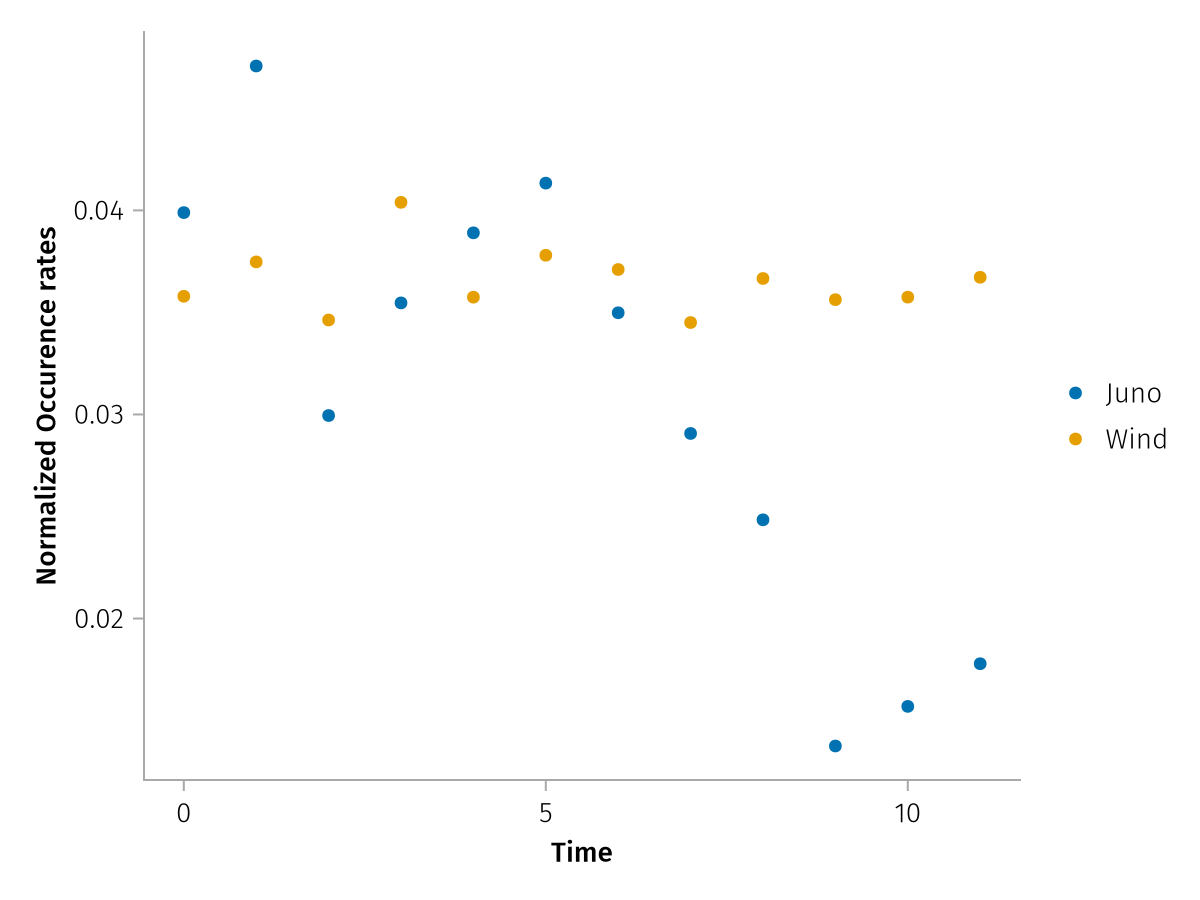

In [30]:
x = :time_bin => "Time"
legends = ["Juno", "Wind"]
specs = data(df) * mapping(x, [:ρ_l, :ρ_1] .=> "Normalized Occurence rates") * mapping(color=dims(1) => renamer(legends))
draw(specs)
easy_save("ocr/ocr_normalized_by_r")

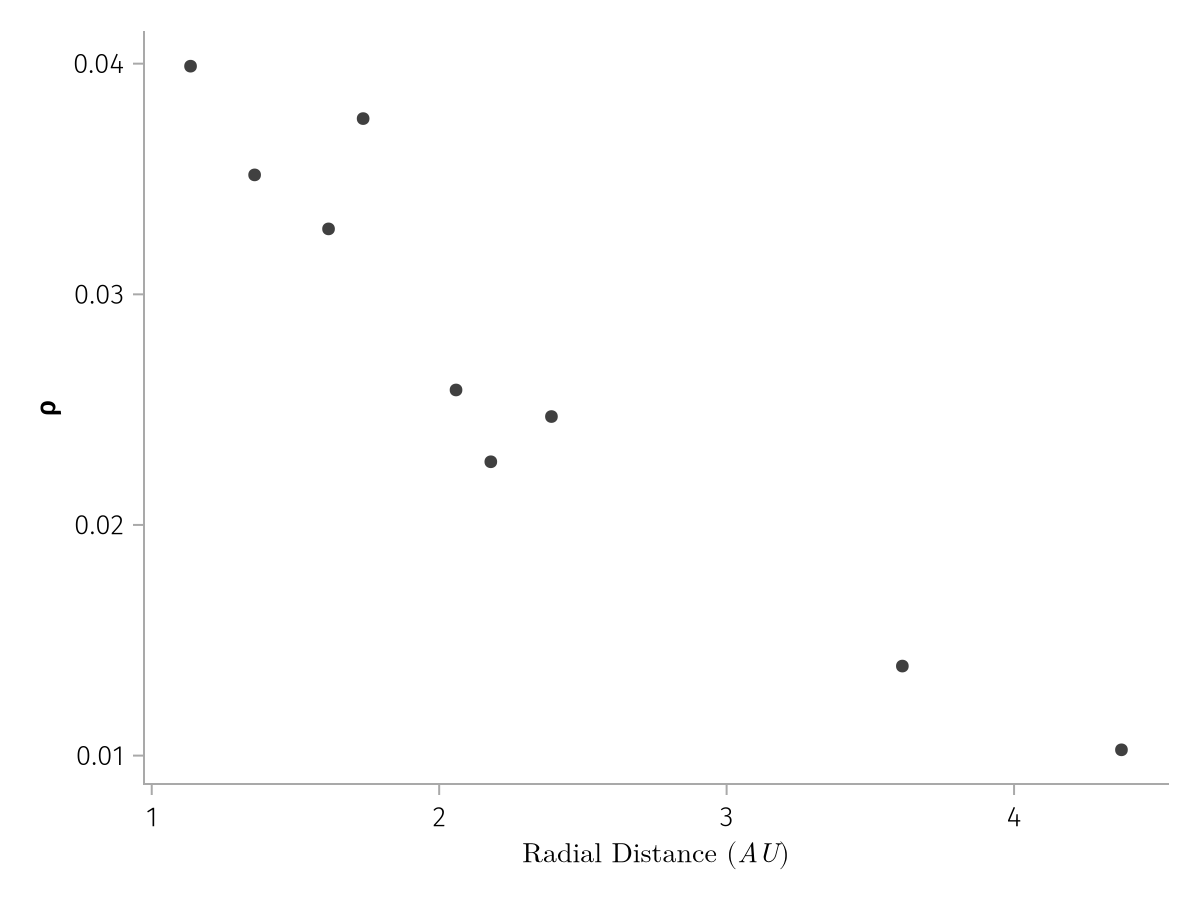

In [12]:
x = :r_mean => r_lab
specs = data(df) * mapping(x, :ρ)
draw(specs)

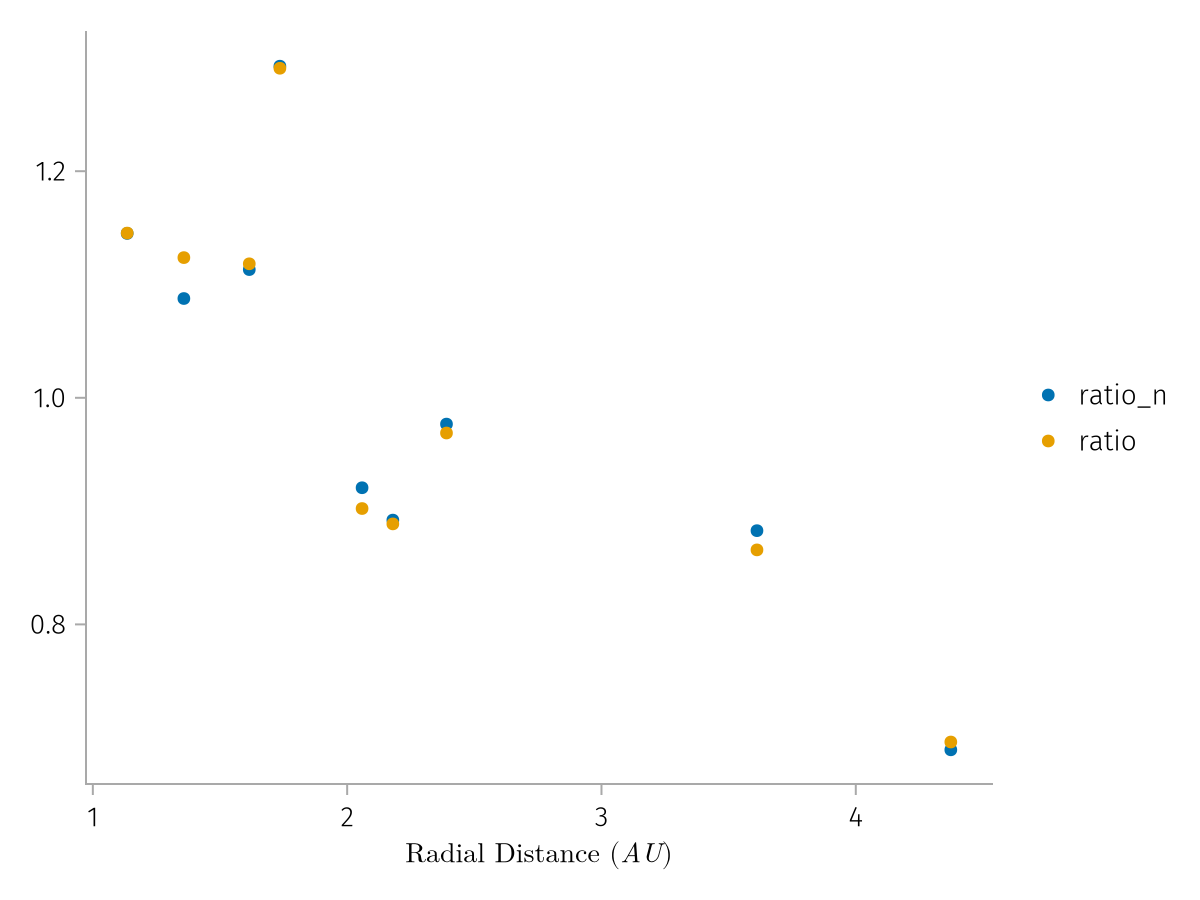

In [109]:
y = [:ratio_n, :ratio]
specs = data(df) * mapping(x) * mapping(y, color=dims(1) => renamer(string.(y)))
plt2 = draw(specs)